# Neural Style Transfer

## Introduction

Neural Style Transfer (NST) was introduced by **Leon Gatys et al. in 2015**. It consists of applying the **style** of a reference image to a target image while conserving the **content**, as exemplified:

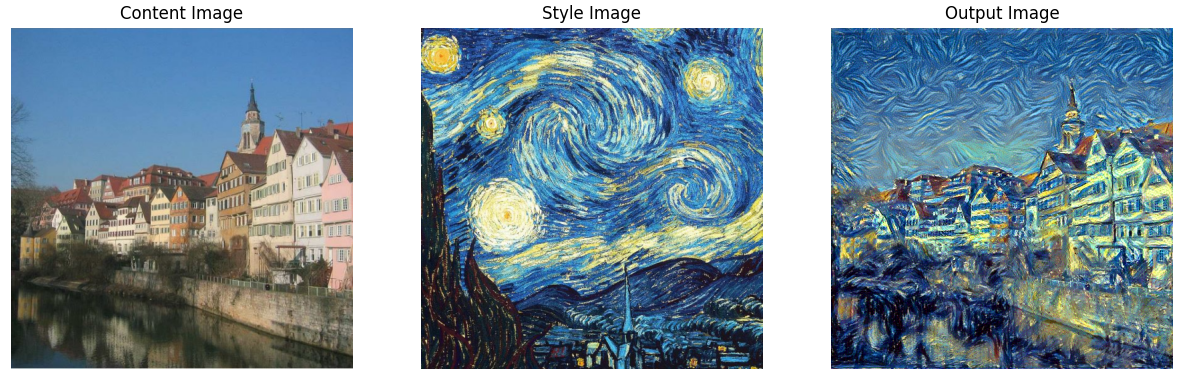

**Style**: Textures, colors, visual patterns across various spatial scales.  
**Content**: Higher-level macrostructure of the image.

The idea of style transfer is related to **texture generation**, which has a long history in image processing before the development of its neural counterpart.

The key notion behind the implementation of NST is the same idea fundamental to all Deep Learning algorithms: definition of a loss function.

In high-level terms, the loss function is defined as:

$$
\mathcal{L}_{\text{style\_transfer}} = \underbrace{\text{distance}(\text{style}(\text{reference\_image}), \text{style}(\text{combination\_image}))}_{\text{Style loss}} + \underbrace{\text{distance}(\text{content}(\text{original\_image}), \text{content}(\text{combination\_image}))}_{\text{Content loss}}
$$

Here:
- $\text{distance}$: A norm function such as $\text{L}_2$ norm.  
- $\text{content}$: A function computing a representation of the image content.  
- $\text{style}$: A function computing the representation of the image style.

Minimizing the loss function ensures:
- $\text{style}(\text{combination\_image}) \approx \text{style}(\text{reference\_image})$,
- $\text{content}(\text{combination\_image}) \approx \text{content}(\text{original\_image})$.

Gatys et al. found that convolutional neural networks (CNNs) offer a way to mathematically define the $\text{style}$ and $\text{content}$ functions.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import copy
import matplotlib.pyplot as plt
import numpy as np
import imageio

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Image loading and preprocessing
def image_loader(image_path, imsize):
    loader = transforms.Compose([
        transforms.Resize(imsize),
        transforms.CenterCrop(imsize),
        transforms.ToTensor()])
    
    image = Image.open(image_path)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# Convert tensor to image for visualization
def tensor_to_image(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    return image

## The Content Loss

The activations from earlier layers in a network contain *local* information, while activations from higher layers capture increasingly global and abstract information. Thus, the **content** of an image, which is more global, is found in the upper-layer representations of a CNN.

Let $F^l \in \mathbb{R}^{C_l \times H_l \times W_l}$ denote the feature map of the generated image at layer $l$, and $P^l$ denote the feature map of the content image at the same layer. Then the content loss is defined as:

$$
\mathcal{L}_{\text{content}} = \frac{1}{2} \sum_{i,j} \left( F_{ij}^l - P_{ij}^l \right)^2
$$

This guarantees that the generated image will maintain high-level structural similarity to the target content image. It assumes that upper layers in a CNN effectively "see" the content of the input images.

In [4]:
# Content and Style losses
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        
    def forward(self, x):
        self.loss = nn.functional.mse_loss(x, self.target)
        return x

## The Style Loss

Unlike content loss, which uses a single upper layer, style loss uses **multiple layers** of a CNN to capture texture patterns across spatial scales.

To model the style of an image, we compute the **Gram matrix** of a layer's activations. The Gram matrix captures the correlations between feature maps at layer $l$, reflecting the texture statistics at that scale.

For a feature map $F^l \in \mathbb{R}^{C_l \times H_l \times W_l}$, the Gram matrix is:

$$
G^l_{ij} = \sum_{k=1}^{H_l W_l} F_{ik}^l F_{jk}^l
$$

where $G^l \in \mathbb{R}^{C_l \times C_l}$. The style loss for layer $l$ is the Frobenius norm between the Gram matrices of the generated image ($G^l$) and the style reference image ($A^l$):

$$
\mathcal{L}_{\text{style}}^l = \frac{1}{4 N_l^2 M_l^2} \sum_{i,j} \left( G_{ij}^l - A_{ij}^l \right)^2
$$

where:
- $N_l = C_l$: Number of feature maps (channels).  
- $M_l = H_l \times W_l$: Number of spatial locations.  

The total style loss aggregates contributions across multiple layers:

$$
\mathcal{L}_{\text{style}} = \sum_{l} w_l \mathcal{L}_{\text{style}}^l
$$

Here, $w_l$ is a weight factor controlling the contribution of layer $l$.

In [5]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target_feature).detach()
        
    def forward(self, x):
        G = self.gram_matrix(x)
        self.loss = nn.functional.mse_loss(G, self.target)
        return x
    
    def gram_matrix(self, x):
        batch_size, n_channels, height, width = x.size()
        features = x.view(batch_size * n_channels, height * width)
        G = torch.mm(features, features.t())
        return G.div(batch_size * n_channels * height * width)

In [6]:
# Normalization class
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
        self.std = torch.tensor(std).view(-1, 1, 1).to(device)

    def forward(self, img):
        return (img - self.mean) / self.std

## Total Loss

The total loss combines content and style losses:

$$
\mathcal{L}_{\text{total}} = \alpha \mathcal{L}_{\text{content}} + \beta \mathcal{L}_{\text{style}}
$$

where:
- $\alpha$: Weight for content preservation.  
- $\beta$: Weight for style transfer.

In [7]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img=None, content_img=None,
                               content_layers=['conv_4'],
                               style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
    
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std)
    
    content_losses = []
    style_losses = []
    
    model = nn.Sequential(normalization)
    
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            continue
            
        model.add_module(name, layer)
        
        # Add content loss if content_img is provided
        if content_img is not None and name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)
            
        # Add style loss if style_img is provided
        if style_img is not None and name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)
    
    # Trim the model after the last loss layer
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    
    model = model[:(i + 1)]
    
    return model, style_losses, content_losses

In [8]:
# Style transfer function
def run_style_transfer(cnn, normalization_mean, normalization_std,
                      content_img, style_img, input_img, num_steps=300,
                      style_weight=500000, content_weight=0.01):
    # Adjust The weights as needed
    
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    
    input_img.requires_grad_(True)
    model.requires_grad_(False)
    
    optimizer = optim.LBFGS([input_img])

    imgs = list()
    
    run = [0]
    while run[0] <= num_steps:
        
        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)
                
            optimizer.zero_grad()
            model(input_img)
            
            style_score = 0
            content_score = 0
            
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
                
            style_score *= style_weight
            content_score *= content_weight
            loss = style_score + content_score
            loss.backward()
            
            run[0] += 1
            if run[0] % 50 == 0:
                print(f"run {run[0]}:")
                print(f'Style Loss : {style_score.item():.4f} Content Loss: {content_score.item():.4f}')

            imgs.append(tensor_to_image(input_img))
                
            return style_score + content_score
        
        optimizer.step(closure)
    
    with torch.no_grad():
        input_img.clamp_(0, 1)
        
    return input_img, imgs

In [9]:
def run_content_optimization(cnn, normalization_mean, normalization_std,
                     content_img, input_img, num_steps=300, content_weight=1):
    
    model, _, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img=None, content_img=content_img)

    input_img.requires_grad_(True)
    model.requires_grad_(False)
    
    optimizer = optim.LBFGS([input_img])

    imgs = list()
    
    run = [0]
    while run[0] <= num_steps:
        
        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)
                
            optimizer.zero_grad()
            model(input_img)
            
            content_score = 0
            for cl in content_losses:
                content_score += cl.loss
                
            content_score *= content_weight
            content_score.backward()
            
            run[0] += 1
            if run[0] % 50 == 0:
                print(f"run {run[0]}:")
                print(f"Content Loss: {content_score.item():.4f}")

            imgs.append(tensor_to_image(input_img))
                
            return content_score
        
        optimizer.step(closure)
    
    with torch.no_grad():
        input_img.clamp_(0, 1)
        
    return input_img, imgs

In [10]:
def run_style_optimization(cnn, normalization_mean, normalization_std,
                   style_img, input_img, num_steps=300, style_weight=5000000):
    
    model, style_losses, _ = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img=style_img, content_img=None)

    input_img.requires_grad_(True)
    model.requires_grad_(False)
    
    optimizer = optim.LBFGS([input_img])

    imgs = list()
    
    run = [0]
    while run[0] <= num_steps:
        
        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)
                
            optimizer.zero_grad()
            model(input_img)
            
            style_score = 0
            for sl in style_losses:
                style_score += sl.loss
                
            style_score *= style_weight
            style_score.backward()
            
            run[0] += 1
            if run[0] % 50 == 0:
                print(f"run {run[0]}:")
                print(f"Style Loss: {style_score.item():.4f}")

            imgs.append(tensor_to_image(input_img))
                
            return style_score
        
        optimizer.step(closure)
    
    with torch.no_grad():
        input_img.clamp_(0, 1)
        
    return input_img, imgs

In [11]:
def main(content_path, style_path, imsize=512, mode='style_transfer', num_steps=1000, style_weight=100000, content_weight=0.01):
    """
    Main function to perform style transfer, content optimization, or style optimization.

    Args:
    - content_path (str): Path to the content image or 'noise' for random noise.
    - style_path (str): Path to the style image or 'noise' for random noise.
    - imsize (int): Image size (default: 512).
    - mode (str): Mode of optimization - 'style_transfer', 'content', or 'style'.
    - num_steps (int): Number of optimization steps (default: 300).
    - style_weight (float): Weight for style loss (default: 500).
    - content_weight (float): Weight for content loss (default: 0.01).
    """

    # Load content image
    if content_path == 'noise':
        content_img = torch.randn((1, 3, imsize, imsize)).to(device, torch.float)
    else:
        content_img = image_loader(content_path, imsize)

    # Load style image
    if style_path == 'noise':
        style_img = torch.randn((1, 3, imsize, imsize)).to(device, torch.float)
    else:
        style_img = image_loader(style_path, imsize)

    # Initialize input image (default to content image clone)
    input_img = content_img.clone()

    # Load VGG19 model
    cnn = models.vgg19(weights='DEFAULT').features.to(device).eval()

    # VGG normalization values
    cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

    # Determine the mode of operation
    if mode == 'content':
        # Content optimization
        print("Performing content optimization...")
        output, imgs = run_content_optimization(cnn, cnn_normalization_mean, cnn_normalization_std, style_img, input_img, 
                                           num_steps=num_steps, content_weight=content_weight)

    elif mode == 'style':
        # Style optimization
        print("Performing style optimization...")
        output, imgs = run_style_optimization(cnn, cnn_normalization_mean, cnn_normalization_std, style_img, input_img, 
                                         num_steps=num_steps, style_weight=style_weight)

    else:
        # Default to full style transfer
        print("Performing style transfer...")
        output, imgs = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, 
                                    content_img, style_img, input_img, 
                                    num_steps=num_steps, style_weight=style_weight, content_weight=content_weight)

    # Display results
    plt.figure(figsize=(15, 5))
    
    if content_img is not None:
        plt.subplot(1, 3, 1)
        plt.imshow(tensor_to_image(content_img))
        title = 'Content Image' if content_path != 'noise' else 'Noise (Content)'
        plt.title(title)
        plt.axis('off')

    if style_img is not None:
        plt.subplot(1, 3, 2)
        plt.imshow(tensor_to_image(style_img))
        title = 'Style Image' if style_path != 'noise' else 'Noise (Style)'
        plt.title(title)
        plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(tensor_to_image(output))
    plt.title('Output Image')
    plt.axis('off')

    # Save the result
    output_name = f"{content_path.split('/')[-1].split('.')[0]}_{style_path.split('/')[-1].split('.')[0]}.jpg"
    plt.savefig(f'img/results/{output_name}')
    plt.show()

    imageio.mimsave(f"img/results/{content_path.split('/')[-1].split('.')[0]}_{style_path.split('/')[-1].split('.')[0]}.gif",
                    imgs, duration=3)

Performing style transfer...


C:\Users\cedri\AppData\Local\Temp\ipykernel_16756\3235729762.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
C:\Users\cedri\AppData\Local\Temp\ipykernel_16756\3235729762.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1).to(device)


run 50:
Style Loss : 0.4728 Content Loss: 0.0518
run 100:
Style Loss : 0.0931 Content Loss: 0.0495
run 150:
Style Loss : 0.0529 Content Loss: 0.0433
run 200:
Style Loss : 0.0317 Content Loss: 0.0393
run 250:
Style Loss : 0.0206 Content Loss: 0.0363
run 300:
Style Loss : 0.0136 Content Loss: 0.0342
run 350:
Style Loss : 0.0090 Content Loss: 0.0326
run 400:
Style Loss : 0.0062 Content Loss: 0.0314
run 450:
Style Loss : 0.0046 Content Loss: 0.0304
run 500:
Style Loss : 0.0037 Content Loss: 0.0295
run 550:
Style Loss : 0.0031 Content Loss: 0.0288
run 600:
Style Loss : 0.0027 Content Loss: 0.0283
run 650:
Style Loss : 0.0025 Content Loss: 0.0278
run 700:
Style Loss : 0.0023 Content Loss: 0.0275
run 750:
Style Loss : 0.0021 Content Loss: 0.0272
run 800:
Style Loss : 0.0020 Content Loss: 0.0270
run 850:
Style Loss : 0.0019 Content Loss: 0.0268
run 900:
Style Loss : 0.0018 Content Loss: 0.0266
run 950:
Style Loss : 0.0017 Content Loss: 0.0264
run 1000:
Style Loss : 0.0016 Content Loss: 0.0263


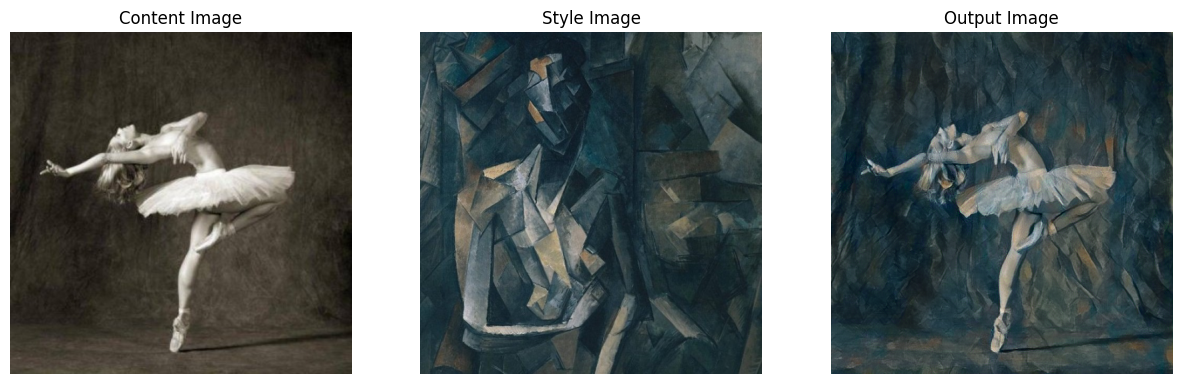

In [12]:
main(content_path='img/content/dancing.jpg', style_path='img/style/picasso.jpg', mode='style_transfer')

Performing content optimization...


C:\Users\cedri\AppData\Local\Temp\ipykernel_16756\3235729762.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
C:\Users\cedri\AppData\Local\Temp\ipykernel_16756\3235729762.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1).to(device)


run 50:
Content Loss: 0.0084
run 100:
Content Loss: 0.0041
run 150:
Content Loss: 0.0026
run 200:
Content Loss: 0.0019
run 250:
Content Loss: 0.0014
run 300:
Content Loss: 0.0010
run 350:
Content Loss: 0.0006
run 400:
Content Loss: 0.0004
run 450:
Content Loss: 0.0003
run 500:
Content Loss: 0.0002
run 550:
Content Loss: 0.0001
run 600:
Content Loss: 0.0002
run 650:
Content Loss: 0.0001
run 700:
Content Loss: 0.0000
run 750:
Content Loss: 0.0000
run 800:
Content Loss: 0.0000
run 850:
Content Loss: 0.0000
run 900:
Content Loss: 0.0000
run 950:
Content Loss: 0.0000
run 1000:
Content Loss: 0.0000


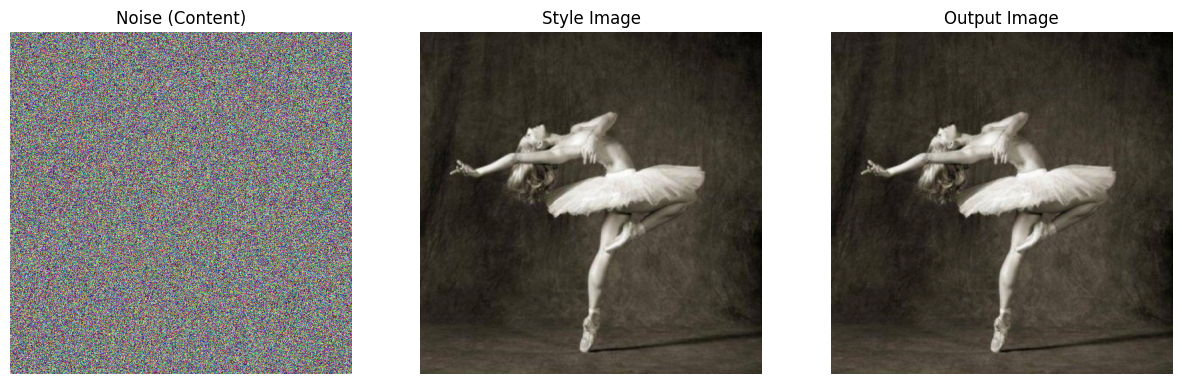

In [13]:
main(content_path='noise', style_path='img/content/dancing.jpg', mode='content')

Performing style optimization...


C:\Users\cedri\AppData\Local\Temp\ipykernel_16756\3235729762.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
C:\Users\cedri\AppData\Local\Temp\ipykernel_16756\3235729762.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1).to(device)


run 50:
Style Loss: 8.1338
run 100:
Style Loss: 2.1727
run 150:
Style Loss: 0.4533
run 200:
Style Loss: 0.1538
run 250:
Style Loss: 0.0916
run 300:
Style Loss: 0.0633
run 350:
Style Loss: 0.0445
run 400:
Style Loss: 0.0309
run 450:
Style Loss: 0.0217
run 500:
Style Loss: 0.0159
run 550:
Style Loss: 0.0119
run 600:
Style Loss: 0.0090
run 650:
Style Loss: 0.0068
run 700:
Style Loss: 0.0052
run 750:
Style Loss: 0.0040
run 800:
Style Loss: 0.0032
run 850:
Style Loss: 0.0025
run 900:
Style Loss: 0.0020
run 950:
Style Loss: 0.0017
run 1000:
Style Loss: 0.0014


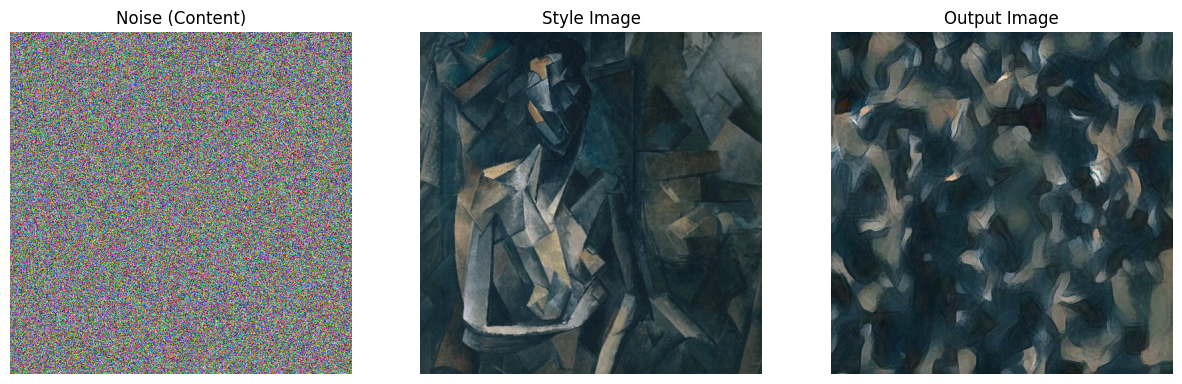

In [14]:
main(content_path='noise', style_path='img/style/picasso.jpg', mode='style')